# Implementación del algoritmo de detección basado en el modelo de Wahl, Sjödahl y Ramser

Basado en el trabajo https://www.doi.org/10.1177/0003702819888949

Carga de librerías externas, nombre del archivo con espectros de entrenamiento y número de archivos de recolección de datos.

In [1]:
import json
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from random import sample, randrange
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score
from keras.layers import Conv1D, Dense, Dropout, AveragePooling1D, BatchNormalization, ReLU, Flatten, Normalization

# Posición más alta del vector que actúa como eje X
max_x = 1024

archivo_entrenamiento = '../resultados_entrenamiento.ndjson'
ruta_guardado_modelo = './modelo_entrenado'

numero_archivos_inferencia = 10

config_wahl_sjodahl_ramser = {
    'dim_filtros': 3,
    'num_filtros_primera_capa': 8,
    'num_filtros_segunda_capa': 16,
    'num_filtros_tercera_capa': 32,
    'dim_average_pooling': 3,
    'tasa_dropout': 0.2,
    'tamano_vector': max_x,
    'tasa_aprendizaje_inicial': 10e-4,
    'momentum': 0.9,
    'mini_batches': 128,
    'epochs': 120,
    'tasa_reduccion_lr': 0.1,
    'reduccion_cada_n_epochs': 10,
    'proporcion_conjunto_prueba': 0.1,
    'proporcion_validacion': 0.1,
    'min_delta_early_stopping': 0.001,
    'paciencia_early_stopping': 10,
    'cargar_modelo': True
}

2022-11-09 13:45:42.238213: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-09 13:45:42.241101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-09 13:45:42.241110: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Funciones de carga de espectros.

In [2]:
def deserializar_espectro(espectro):
    espectro['vector_base'] = np.array(espectro['vector_base'])
    espectro['espectro_base_muestra'] = np.array(espectro['espectro_base_muestra'])
    espectro['espectro_base_background'] = np.array(espectro['espectro_base_background'])
    espectro['baseline_muestra'] = np.array(espectro['baseline_muestra'])
    espectro['baseline_background'] = np.array(espectro['baseline_background'])
    espectro['muestra_con_baseline'] = np.array(espectro['muestra_con_baseline'])
    espectro['background_con_baseline'] = np.array(espectro['background_con_baseline'])
    espectro['muestra_combinado_base'] = np.array(espectro['muestra_combinado_base'])
    espectro['espectro_ruido_combinado'] = np.array(espectro['espectro_ruido_combinado'])
    espectro['espectro_ruido_background'] = np.array(espectro['espectro_ruido_background'])
    espectro['spikes_muestra'] = np.array(espectro['spikes_muestra'])
    espectro['spikes_background'] = np.array(espectro['spikes_background'])
    espectro['flag_spikes_muestra'] = np.array(espectro['flag_spikes_muestra'])
    espectro['flag_spikes_background'] = np.array(espectro['flag_spikes_background'])
    espectro['muestra_base_con_spikes'] = np.array(espectro['muestra_base_con_spikes'])
    espectro['y_muestra'] = np.array(espectro['y_muestra'])
    espectro['y_background'] = np.array(espectro['y_background'])

    return espectro

def cargar_espectros(nombre_archivo):
    with open(nombre_archivo, 'r') as fp:
        data = []
        for line in fp:
            data.append(deserializar_espectro(json.loads(line)))
        fp.close()
        return data

espectros = cargar_espectros(archivo_entrenamiento)

Función para calcular métricas de clasificación de spikes.

In [3]:
def calcular_metricas_clasificacion(valores_reales, predicciones):
    _predicciones = np.array(predicciones).flatten()
    _valores_reales = np.array(valores_reales).flatten()

    return precision_recall_fscore_support(_valores_reales, _predicciones), confusion_matrix(_valores_reales, _predicciones)

Separación del conjunto de datos en conjuntos de prueba y entrenamiento

In [4]:
espectros_entrenamiento, espectros_prueba = train_test_split(espectros, test_size=config_wahl_sjodahl_ramser['proporcion_conjunto_prueba'])

etiquetas_entrenamiento = [espectro['spikes_muestra'] for espectro in espectros_entrenamiento]
etiquetas_prueba = [espectro['spikes_muestra'] for espectro in espectros_prueba]

muestras_ruido_multiple_entrenamiento = [espectro['muestra_base_con_spikes'] for espectro in espectros_entrenamiento]
muestras_ruido_multiple_prueba = [espectro['muestra_base_con_spikes'] for espectro in espectros_prueba]

Implementación de un algoritmo basado en el modelo Wahl-Sjödahl-Ramser para detección de spikes, así como funciones auxiliares para recogida de datos y visualización de resultados.

In [5]:
def obtener_resultado_modelo_entrenado(modelo_entrenado, input_prueba, etiquetas_prueba, tamano_vector, umbral = 0.1):
    predicciones_wahl_sjodahl_ramser, forma = realizar_prediccion_modelo_entrenado(
        modelo_entrenado,
        input_prueba,
        tamano_vector,
        umbral
    )

    return predicciones_wahl_sjodahl_ramser, calcular_metricas_clasificacion(etiquetas_prueba, predicciones_wahl_sjodahl_ramser)

def realizar_prediccion_modelo_entrenado(modelo_entrenado, vector_input, tamano_vector, umbral = 0.1):
    X, y = preprocesar_input_modelo(vector_input, tamano_vector)

    forma = modelo_entrenado.predict(X)
    predicciones = forma > umbral
    return predicciones, forma

def preprocesar_input_modelo(vector_input, tamano_vector, posicion_spikes = None):
    if len(vector_input) == 0:
        return np.array([]), np.array([])

    X = np.array(vector_input)
    X = X.reshape(X.shape[0], tamano_vector, 1)

    y = np.array([])

    if posicion_spikes != None:
        y = np.array(posicion_spikes)
        y = y.reshape(y.shape[0], tamano_vector, 1)

    return X, y

def visualizar_resultado_modelo(vector_base, modelo_entrenado, vector_input, etiquetas, tamano_vector, umbral = 0.1):
    detecciones, forma = realizar_prediccion_modelo_entrenado(
        modelo_entrenado,
        vector_input,
        tamano_vector,
        umbral
    )

    detecciones = detecciones[0]
    forma = forma[0]

    fig = plt.figure(figsize=[45, 15], constrained_layout=True)

    fig.suptitle("Muestra de resultados al aplicar el algoritmo Wahl-Sjodahl-Ramser", fontsize=24, fontweight='bold')

    subfigs = fig.subfigures(nrows=3, ncols=1)

    for row, subfig in enumerate(subfigs):
        (ax) = subfig.subplots(nrows=1, ncols=1)

        if row == 0:
            ax.set_title("Serie original", fontsize=18)
            ax.plot(vector_base, vector_input[0])
        elif row == 1:
            ax.set_title("Detección como output del modelo", fontsize=18)
            ax.plot(vector_base, forma)
        elif row == 2:
            categorias = {
                'tp': {
                    'color': 'blue',
                    'label': 'Detecciones'
                },
                'fp': {
                    'color': 'black',
                    'label': 'Falsos positivos'
                },
                'fn': {
                    'color': 'red',
                    'label': 'Falsos negativos'
                }
            }

            detecciones_agrupadas = []

            for i, es_resultado in enumerate(detecciones):
                label = ''
                es_spike = etiquetas[i]

                if es_spike:
                    if es_resultado:
                        label = 'tp'
                    else:
                        label = 'fn'
                elif es_resultado:
                    label = 'fp'
                else:
                    label = 'tn'
                detecciones_agrupadas.append(label)

            detecciones_agrupadas = np.array(detecciones_agrupadas)

            ax.set_title("Serie con spikes detectados y tipos de detección", fontsize=18)
            ax.plot(vector_base, vector_input[0])
            ax.scatter(vector_base[detecciones_agrupadas == 'tp'], vector_input[0][detecciones_agrupadas == 'tp'], c=categorias['tp']['color'], label=categorias['tp']['label'], s=100)
            ax.scatter(vector_base[detecciones_agrupadas == 'fp'], vector_input[0][detecciones_agrupadas == 'fp'], c=categorias['fp']['color'], label=categorias['fp']['label'], s=100)
            ax.scatter(vector_base[detecciones_agrupadas == 'fn'], vector_input[0][detecciones_agrupadas == 'fn'], c=categorias['fn']['color'], label=categorias['fn']['label'], s=100)

            ax.legend(fontsize=28)


def modelo_wahl_sjodahl_ramser(vector_input, posicion_spikes, config_modelo):
    dim_filtros = config_modelo["dim_filtros"]
    num_filtros_primera_capa = config_modelo["num_filtros_primera_capa"]
    num_filtros_segunda_capa = config_modelo["num_filtros_segunda_capa"]
    num_filtros_tercera_capa = config_modelo["num_filtros_tercera_capa"]
    dim_average_pooling = config_modelo["dim_average_pooling"]
    tasa_dropout = config_modelo["tasa_dropout"]
    tamano_vector = config_modelo["tamano_vector"]
    tasa_aprendizaje_inicial = config_modelo["tasa_aprendizaje_inicial"]
    momentum = config_modelo["momentum"]
    epochs = config_modelo["epochs"]
    proporcion_validacion = config_modelo['proporcion_validacion']
    min_delta = config_modelo['min_delta_early_stopping']
    paciencia = config_modelo['paciencia_early_stopping']

    X, y = preprocesar_input_modelo(
        vector_input,
        tamano_vector,
        posicion_spikes=posicion_spikes
    )

    numero_neuronas = tamano_vector 
    input_shape = (tamano_vector, 1)

    modelo = Sequential()

    normalizador = Normalization(input_shape=input_shape)

    normalizador.adapt(X)

    modelo.add(normalizador)

    modelo.add(Conv1D(num_filtros_primera_capa, dim_filtros, data_format='channels_last', name="conv1"))
    modelo.add(BatchNormalization())
    modelo.add(ReLU())
    modelo.add(AveragePooling1D(pool_size=dim_average_pooling))
    modelo.add(Conv1D(num_filtros_segunda_capa, dim_filtros, name="conv2"))
    modelo.add(BatchNormalization())
    modelo.add(ReLU())
    modelo.add(AveragePooling1D(pool_size=dim_average_pooling))
    modelo.add(Conv1D(num_filtros_tercera_capa, dim_filtros, name="conv3"))
    modelo.add(BatchNormalization())
    modelo.add(ReLU())
    modelo.add(Conv1D(num_filtros_tercera_capa, dim_filtros, name="conv4"))
    modelo.add(BatchNormalization())
    modelo.add(ReLU())
    modelo.add(Flatten())
    modelo.add(Dropout(tasa_dropout))
    modelo.add(Dense(numero_neuronas, activation="relu"))
    modelo.add(Dense(numero_neuronas, activation="relu"))

    modelo.compile(
        optimizer=SGD(
            learning_rate=tasa_aprendizaje_inicial,
            momentum=momentum
        ),
        loss="mean_squared_error",
    )

    callback = EarlyStopping(
        monitor="val_loss",
        min_delta=min_delta,
        patience=paciencia,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )


    print(modelo.summary())

    historial = modelo.fit(
        X,
        y,
        epochs=epochs,
        validation_split=proporcion_validacion,
        callbacks=[callback]
    )

    return modelo, historial

Carga del modelo entrenado o entrenamiento y guardado del modelo (según corresponda)

In [6]:
modelo_wahl_sjodahl_ramser_entrenado = None
historial_entrenamiento = None

if config_wahl_sjodahl_ramser['cargar_modelo']:
    modelo_wahl_sjodahl_ramser_entrenado = tf.keras.models.load_model(ruta_guardado_modelo)
else:
    modelo_wahl_sjodahl_ramser_entrenado, historial_entrenamiento = modelo_wahl_sjodahl_ramser(
        muestras_ruido_multiple_entrenamiento,
        etiquetas_entrenamiento,
        config_wahl_sjodahl_ramser
    )

    modelo_wahl_sjodahl_ramser_entrenado.save(ruta_guardado_modelo)

2022-11-09 13:45:47.625079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 13:45:47.625702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-09 13:45:47.625751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-09 13:45:47.625790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-09 13:45:47.625815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Prueba del modelo entrenado, para detectar posible overfitting

In [7]:
X_prueba, y_prueba = preprocesar_input_modelo(
    muestras_ruido_multiple_prueba,
    max_x,
    etiquetas_prueba,
)

if not config_wahl_sjodahl_ramser['cargar_modelo']:
    resultado_evaluacion_modelo = modelo_wahl_sjodahl_ramser_entrenado.evaluate(X_prueba, y_prueba, verbose=2)
    with open('historial_entrenamiento_wahl_sjodahl_ramser', 'wb') as fp:
        pickle.dump({
            'historial_entrenamiento': historial_entrenamiento,
            'validacion': resultado_evaluacion_modelo
        }, fp)
        fp.close()

Recogida de datos y guardado de los resultados en un archivo.

In [8]:
resultados_wahl_sjodahl_ramser_ruido = [{ 'param': {}, 'resultados': [] } for _ in range(numero_archivos_inferencia)]
resultados_wahl_sjodahl_ramser_sin_ruido = [{ 'param': {}, 'resultados': [] } for _ in range(numero_archivos_inferencia)]

for i in range(numero_archivos_inferencia):
    nombre_archivo = '../resultados_' + str(i) + '.ndjson'

    espectros = cargar_espectros(nombre_archivo)

    espectros_base_con_spikes_con_ruido = []
    espectros_base_con_spikes_sin_ruido = []
    etiquetas = []

    for espectro in espectros:
        espectros_base_con_spikes_con_ruido.append(espectro['muestra_base_con_spikes'])
        espectros_base_con_spikes_sin_ruido.append(espectro['espectro_base_muestra'] + espectro['spikes_muestra'])
        etiquetas.append(espectro['flag_spikes_muestra'])

    predicciones_wahl_sjodahl_ramser_ruido, metricas_wahl_sjodahl_ramser_ruido = obtener_resultado_modelo_entrenado(
        modelo_wahl_sjodahl_ramser_entrenado,
        espectros_base_con_spikes_con_ruido,
        etiquetas,
        config_wahl_sjodahl_ramser['tamano_vector']
    )
    predicciones_wahl_sjodahl_ramser_sin_ruido, metricas_wahl_sjodahl_ramser_sin_ruido = obtener_resultado_modelo_entrenado(
        modelo_wahl_sjodahl_ramser_entrenado,
        espectros_base_con_spikes_sin_ruido,
        etiquetas,
        config_wahl_sjodahl_ramser['tamano_vector']
    )

    resultados_wahl_sjodahl_ramser_ruido[i]['resultados'].append({
        'precision_negativos': metricas_wahl_sjodahl_ramser_ruido[0][0][0],
        'precision_positivos': metricas_wahl_sjodahl_ramser_ruido[0][0][1],
        'support_negativos': metricas_wahl_sjodahl_ramser_ruido[0][1][0],
        'support_positivos': metricas_wahl_sjodahl_ramser_ruido[0][1][1],
        'f1_negativos': metricas_wahl_sjodahl_ramser_ruido[0][2][0],
        'f1_positivos': metricas_wahl_sjodahl_ramser_ruido[0][2][1],
        'vn': metricas_wahl_sjodahl_ramser_ruido[1][0][0],
        'fp': metricas_wahl_sjodahl_ramser_ruido[1][0][1],
        'fn': metricas_wahl_sjodahl_ramser_ruido[1][1][0],
        'vp': metricas_wahl_sjodahl_ramser_ruido[1][1][1]
    })

    resultados_wahl_sjodahl_ramser_sin_ruido[i]['resultados'].append({
        'precision_negativos': metricas_wahl_sjodahl_ramser_sin_ruido[0][0][0],
        'precision_positivos': metricas_wahl_sjodahl_ramser_sin_ruido[0][0][1],
        'support_negativos': metricas_wahl_sjodahl_ramser_sin_ruido[0][1][0],
        'support_positivos': metricas_wahl_sjodahl_ramser_sin_ruido[0][1][1],
        'f1_negativos': metricas_wahl_sjodahl_ramser_sin_ruido[0][2][0],
        'f1_positivos': metricas_wahl_sjodahl_ramser_sin_ruido[0][2][1],
        'vn': metricas_wahl_sjodahl_ramser_sin_ruido[1][0][0],
        'fp': metricas_wahl_sjodahl_ramser_sin_ruido[1][0][1],
        'fn': metricas_wahl_sjodahl_ramser_sin_ruido[1][1][0],
        'vp': metricas_wahl_sjodahl_ramser_sin_ruido[1][1][1]
    })

with open('resultados_wahl_sjodahl_ramser_ruido', 'wb') as fp:
    pickle.dump(resultados_wahl_sjodahl_ramser_ruido, fp)
    fp.close()

with open('resultados_wahl_sjodahl_ramser_sin_ruido', 'wb') as fp:
    pickle.dump(resultados_wahl_sjodahl_ramser_sin_ruido, fp)
    fp.close()

4/4 [==============================] - 0s 3ms/step


Aquí obtenemos y guardamos en un archivo los peores resultados obtenidos por el algoritmo con sus mejores parámetros (con o sin ruido) para posterior análisis

In [9]:
archivo_azar = randrange(numero_archivos_inferencia)

nombre_archivo = '../resultados_' + str(archivo_azar) + '.ndjson'

espectros = cargar_espectros(nombre_archivo)

prediccion_con_ruido = realizar_prediccion_modelo_entrenado(
    modelo_wahl_sjodahl_ramser_entrenado,
    [espectro['muestra_base_con_spikes'] for espectro in espectros],
    config_wahl_sjodahl_ramser['tamano_vector']
)[0]

prediccion_sin_ruido = realizar_prediccion_modelo_entrenado(
    modelo_wahl_sjodahl_ramser_entrenado,
    [espectro['espectro_base_muestra'] + espectro['spikes_muestra'] for espectro in espectros],
    config_wahl_sjodahl_ramser['tamano_vector']
)[0]

resultados_f1_ruido = [(
    espectro['muestra_base_con_spikes'],
    f1_score(
        espectro['flag_spikes_muestra'],
        prediccion_con_ruido[i],
        zero_division=1
    ),
    espectro['flag_spikes_muestra'],
    {}
) for i, espectro in enumerate(espectros)]

resultados_f1_sin_ruido = [(
    espectro['espectro_base_muestra'] + espectro['spikes_muestra'],
    f1_score(
        espectro['flag_spikes_muestra'],
        prediccion_sin_ruido[i],
        zero_division=1
    ),
    espectro['flag_spikes_muestra'],
    {}
) for i, espectro in enumerate(espectros)]

resultados_f1_ruido = list(filter(lambda d: d[1] > 0, resultados_f1_ruido))
resultados_f1_sin_ruido = list(filter(lambda d: d[1] > 0, resultados_f1_sin_ruido))

resultados_f1_ruido = sorted(resultados_f1_ruido, key=lambda d: d[1])
resultados_f1_sin_ruido = sorted(resultados_f1_sin_ruido, key=lambda d: d[1])

with open('peores_resultados_wahl_sjodahl_ramser', 'wb') as fp:
    peores_resultados_ruido = resultados_f1_ruido[0:10]
    peores_resultados_sin_ruido = resultados_f1_sin_ruido[0:10]
    peores_resultados = {
        'ruido': peores_resultados_ruido,
        'sin_ruido': peores_resultados_sin_ruido
    }
    pickle.dump(peores_resultados, fp)
    fp.close()

4/4 [==============================] - 0s 3ms/step


Toma de una muestra aleatoria de los resultados para control de calidad

In [10]:
indice_muestra = sample(list(range(len(espectros))), 1)[0]

Visualización del resultado de la aplicación del algoritmo a un espectro aleatorio al que no le fue añadido ruido aleatorio

1/1 [==============================] - 0s 12ms/step


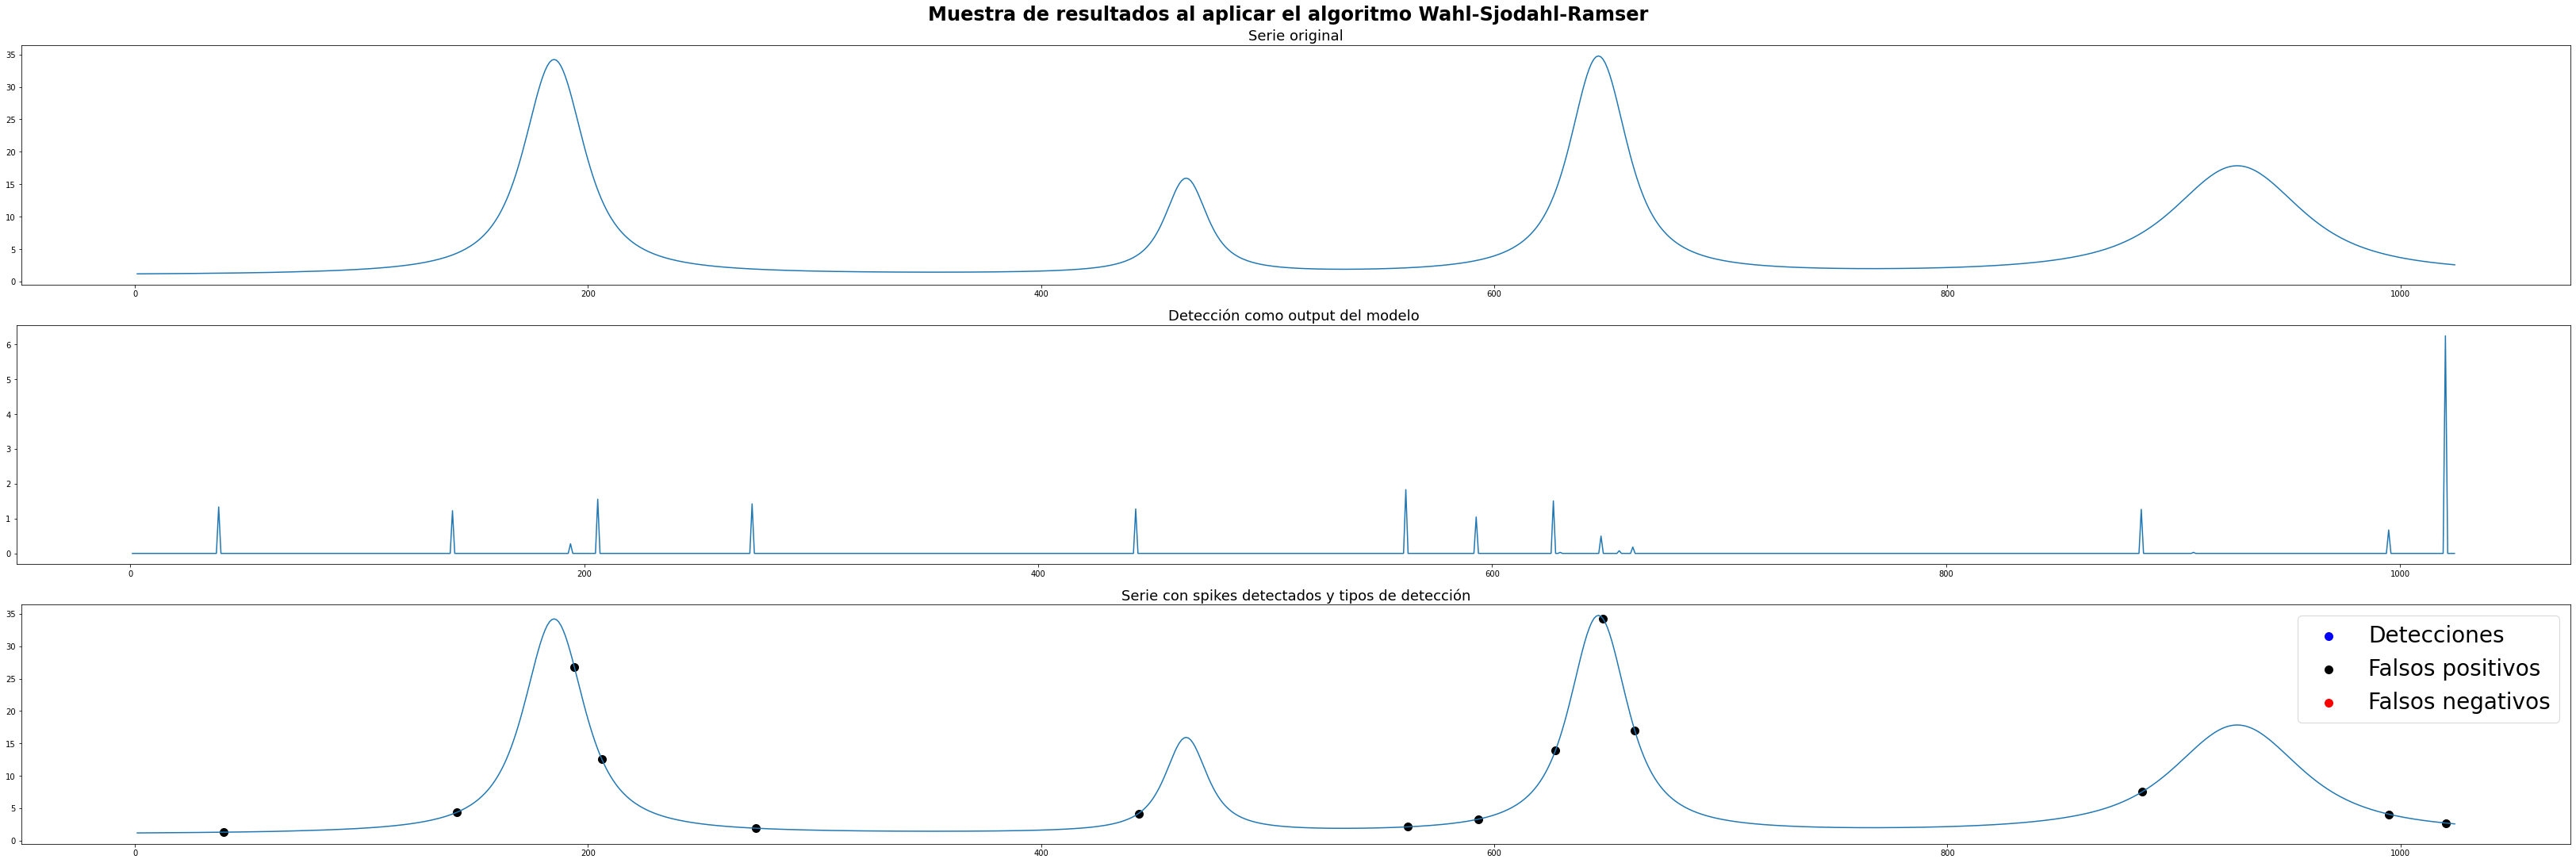

In [11]:
visualizar_resultado_modelo(
    espectros[indice_muestra]['vector_base'],
    modelo_wahl_sjodahl_ramser_entrenado,
    [espectros[indice_muestra]['espectro_base_muestra'] + espectros[indice_muestra]['spikes_muestra']],
    espectros[indice_muestra]['flag_spikes_muestra'],
    config_wahl_sjodahl_ramser['tamano_vector']
)

Visualización del resultado de la aplicación del algoritmo Whitaker-Hayes a un espectro aleatorio al que le fue añadido ruido aleatorio

1/1 [==============================] - 0s 11ms/step


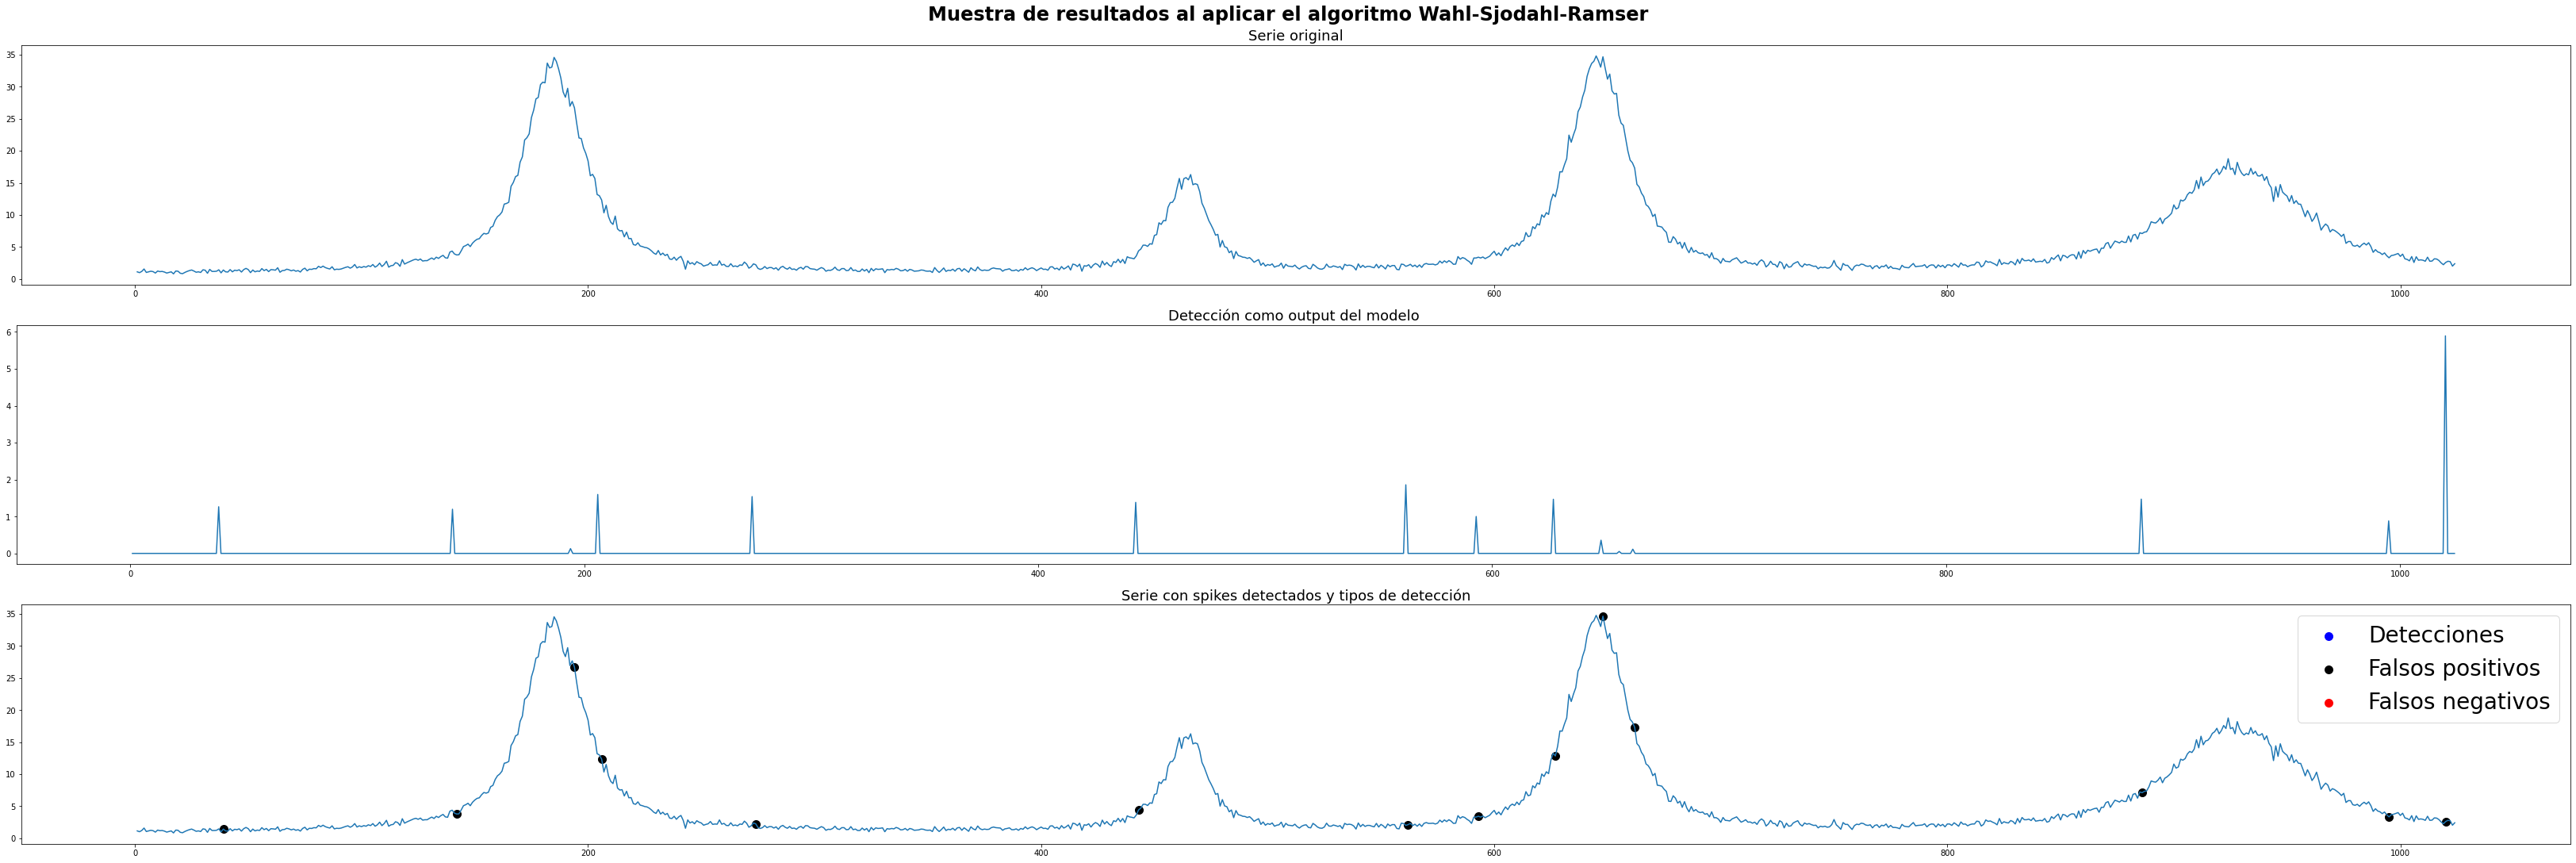

In [12]:
visualizar_resultado_modelo(
    espectros[indice_muestra]['vector_base'],
    modelo_wahl_sjodahl_ramser_entrenado,
    [espectros[indice_muestra]['muestra_base_con_spikes']],
    espectros[indice_muestra]['flag_spikes_muestra'],
    config_wahl_sjodahl_ramser['tamano_vector']
)